## 🔍 Executive Summary

This project applies a Convolutional Neural Network (CNN) to classify chest X-ray images into three categories: **Covid-19**, **Viral Pneumonia**, and **Normal (Healthy)**. The goal is to build an accurate diagnostic model using image recognition techniques on a small but labeled medical dataset of 251 X-rays.
* Results: A model was trained and tested that delivered 99%+ accuracy on both the training and test set, with 91% on the validation set.  

### ✅ Key Results:
- **Training Accuracy:** 99.1%  
- **Validation Accuracy:** 91.3%  
- **Test Accuracy:** 100%  
- **Test Loss:** 0.0579  
- **Confusion Matrix:** All test samples were **correctly classified** (100% classification accuracy)

### 🧠 Model Details:
- CNN with two convolutional layers and one dense layer of 200 neurons  
- Trained over 19 epochs on resized 64×64 color X-ray images  
- Used softmax activation for multi-class classification  

### ⚠️ Limitations:
While model performance is exceptional on this dataset, the small sample size (251 images) limits generalizability. Additional data and external validation are recommended to assess robustness in real-world clinical scenarios.


## 📚 Table of Contents

1. [Executive Summary](#executive-summary)
2. [Dataset Information](#dataset-information)
3. [Library Import](#library-Import)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [Data Preprocessing](#data-preprocessing)
6. [Model Architecture (CNN)](#model-architecture-cnn)
7. [Model Training](#model-training)
8. [Model Evaluation](#model-evaluation)
9. [Confusion Matrix & Interpretation](#confusion-matrix--interpretation)
10. [Conclusions](#conclusions)


------------------------
## **Dataset Information**
----------------
- This dataset contains X-ray images of 3 classes (Covid-19, viral pneumonia, normal (healthy)), which are converted into Numpy arrays. 
- Class description: 
    - COVID-19: Patients who are confirmed case of COVID-19.
    - Viral Pneumonia: Viral infection with some similar traits to COVID-19, but less severe condition.
    - Normal (Healthy): Patients with neither Covid-19 or viral pneumonia diagnosis.
- Dataset file names:
    - CovidImages.npy
    - CovidLabels.csv

# **Library Import**

In [68]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import random

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization 
                                                                                                 # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam, SGD                                                # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Display images using OpenCV
from matplotlib import pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Load the .npy file. Images have already been converted to a npy array format.
images = np.load("CovidImages.npy")

# Inspect the shape and type
print(type(images))
print(images.shape)

<class 'numpy.ndarray'>
(251, 128, 128, 3)


In [70]:
#Import labels as a dataframe with one column
labels = pd.read_csv("CovidLabels.csv")
print(labels.shape)
labels.head()

(251, 1)


,Label
0,Viral Pneumonia
1,Viral Pneumonia
2,Viral Pneumonia
3,Viral Pneumonia
4,Viral Pneumonia


So we have 251 images matching 251 labels stored in a 4-D array, with each dimensions connotating
- 251: number of images
- 128: number of x-axis pixels
- 128: number of y-axis pixels
- 3: number of channels


## **Exploratory Data Analysis (EDA)** 

Converting Numpy arrays to visualize images.
Let's start by writing a function that visualizes our classified images using the array data and labels.

In [71]:
def image_visuals(images, labels, rows, cols):
    #First define local constants, variables, graph size
    num_classes = 10
    categories = np.unique(labels) #get the unique set of classes
    keys = dict(labels['Label']) #create dictionary of labels
    #rows = 4 #number of rows in subplot of images
    #cols = 4 #number of columns in subplot of images
    fig = plt.figure(figsize = (10,8)) #define plot size to be 10x8
    
    #Now create a loop that generates each image indexed to a label
    for i in range(cols):
        for j in range (rows):
            randomizer = np.random.randint(0,len(labels)) #Generate random indices so that subplot pulls randomly from dataset
            ax = fig.add_subplot(rows,cols, i*rows+j+1) #create subplot of first 12 images
            ax.imshow(images[randomizer,:])
            ax.set_title(keys[randomizer])
    plt.show()
    
    
    

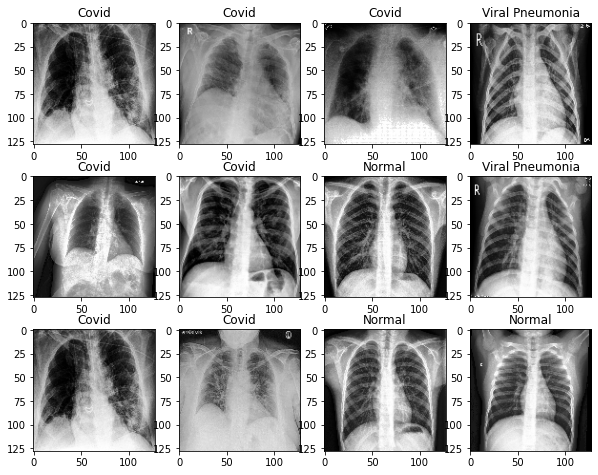

In [72]:
image_visuals(images, labels,3,4)

Making some qualitative observations, viral pneumonia has enlarged hearts compared to normal. Covid x-rays seem to be more variable. Let's see how the class distribution rate visually:

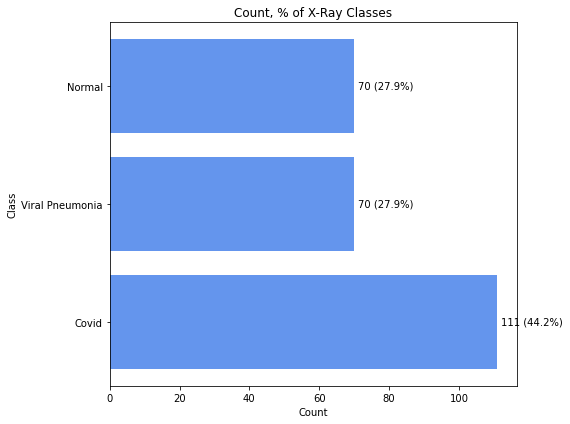

In [73]:
label_counts = labels['Label'].value_counts()
label_percent = (label_counts/label_counts.sum())*100


# Create labels like "123 (45.6%)"
label_bars = [f'{count} ({pct:.1f}%)' for count, pct in zip(label_counts, label_percent)]
#Plot
plt.figure(figsize = (8,6))
bars = plt.barh(label_counts.index.astype(str), label_counts.values, color = 'cornflowerblue')

#Create chart
for bar, label in zip(bars, label_bars):
    plt.text(bar.get_width() + max(label_counts.values)*.01,
            bar.get_y() + bar.get_height()/2,
            label, va ='center', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Count, % of X-Ray Classes')
plt.tight_layout()
plt.show()


So a plurality of X-rays are Covid (44%), while the remaining are split equally between pneumonia and normal (28%).  Let's start by reducing the size of the images to make it easier computationally to train a classification model.

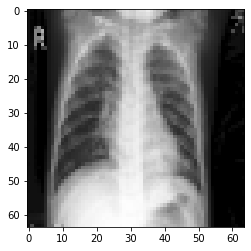

In [74]:
images_resized = []
dimensions = (64,64) #set new images dimensions to 64x64
for i in range(len(images)):
    images_resized.append(cv2.resize(images[i],dimensions,interpolation = cv2.INTER_LINEAR))
plt.imshow(images_resized[1]) #show an example of one of the resized images

As expected, a bit coarser than the original images, but should still be suitable for traning.

## **Data Preprocessing**

- To start, let's split the dataset into training and testing sets. Since we have a relatively small dataset to work with, let's use 90% of our images to train and the remaining 10% to test.


In [75]:
train_size = .9 #90% of dataset will be used to train
test_size = 1-train_size #remainder (ie. 10%) will be used to test

X_train, X_test, y_train, y_test = train_test_split(
    np.array(images_resized),
    labels,
    test_size=test_size,
    random_state=42,
    stratify=labels
)
print("Training set dimensions, images & labels:",X_train.shape,",", y_train.shape)
print("Testing set dimensions, images & labels:",X_test.shape,",", y_test.shape)

Training set dimensions, images & labels: (225, 64, 64, 3) , (225, 1)
Testing set dimensions, images & labels: (26, 64, 64, 3) , (26, 1)


Since there are 3 classes, the output layer should have 3 corresponding neurons providing the probabilities of the input image belonging to each of those 3 classes. We will use the Softmax activation function to encode our representation of the target label classes.

In [76]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded = enc.transform(y_test)
enc.classes_

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [77]:
y_train_encoded.shape,y_test_encoded.shape

((225, 3), (26, 3))

We now have three columns in the target corresponding to each class. Now, let's move onto normalizing our image data.

In [78]:
# Normalizing the image pixels
pixel_max = 255.0 #Max number of pixels
X_train_normalized = X_train.astype('float32')/pixel_max
X_test_normalized = X_test.astype('float32')/pixel_max

## **Model Architecture (CNN)**
Let's create a CNN model adding layer upon layer.
*   Let's clear the prior model's history from each session even if a single model can run multiple times on the same data and then fix the seed value.
* Let's set the seed for random number generators in both numpy and tensorflow so that the results will be reproduced every time the code is run.

In [79]:
#Let's re-import the libraries needed for this again
from tensorflow.keras import backend
import numpy as np
import random
import tensorflow as tf

backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Let's build a CNN Model with:

* The Feature Extraction layers (convolutional and pooling layers)
* A fully connected classification layer for prediction

In [80]:
#First, let's code some variables to store peramater values
filter1 = 128 #setting the first number of filters (kernels) to 128
filter2 = 64 #setting the second number of filters (kernels) to 64
filter_size = (3,3) #size of each filter is 3x3 pixels
input_dim = (64,64,3) #image input shape - 64x64 pixels by 3 channels (colors)
max_dim = (2,2) #set max pooling dimension to reduce dimensions by half
neurons1 = 200 #Set the number of neurons to 100 for the first dense layer
neurons_output = 3 #Set the number of output neurons
disable_rate =.3 #Set the model to disable 30% of neurons at the time to prevent overfitting

#Create our first model (model1) as a sequential model to add each layer one at a time
model1 = Sequential()
#Add first later to pull in input image array values
model1.add(Conv2D(filter1, filter_size, activation = 'relu', padding = "same", input_shape = input_dim))
#Add a max pooling layer to reduce the output layer
model1.add(MaxPooling2D(max_dim, padding = 'same'))
#Add a second layer to the model with the same previous dimensions
model1.add(Conv2D(filter2, filter_size, activation = 'relu', padding = "same"))
#Add another max pooling layer to reduce the output layer
model1.add(MaxPooling2D(max_dim, padding = 'same'))
# flattening the output of the output layer after max pooling to make it ready for the dense, fully connected layer
model1.add(Flatten())
# Adding a fully connected, dense layer with 8 neurons    
model1.add(Dense(neurons1, activation = 'relu'))
#Disable certain amount of neurons randomly
model1.add(Dropout(disable_rate))
#Add output layer. Set activation to softmax due to multi-class classification.
model1.add(Dense(neurons_output, activation = 'softmax'))

#Set optimizer to Adam, preferred for multi-class image classification
opt=Adam()

# Compile model layers together
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     3,277,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,354,979 (12.80 MB)

 Trainable params: 3,354,979 (12.80 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**
Now let's fit the model to the training data.

In [81]:
#Set constants to pass in
cycles_1 = 19 #Set the initial number of training cycles (epochs) to 10
batches = 64 #Set the number of samples analyzed in each cycle

history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs = cycles_1, #Set variable outside model code
            validation_split = .1, #Previously we set the test size to .1
            shuffle = False,
            batch_size = batches,
            verbose = 1
)

Epoch 1/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 725ms/step - accuracy: 0.4274 - loss: 1.6702 - val_accuracy: 0.1739 - val_loss: 1.1224
Epoch 2/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.4205 - loss: 1.0907 - val_accuracy: 0.4783 - val_loss: 1.0187
Epoch 3/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5664 - loss: 1.0016 - val_accuracy: 0.6522 - val_loss: 0.8601
Epoch 4/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.6782 - loss: 0.7947 - val_accuracy: 0.7826 - val_loss: 0.5327
Epoch 5/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.8545 - loss: 0.4794 - val_accuracy: 0.8261 - val_loss: 0.4461
Epoch 6/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9079 - loss: 0.2775 - val_accuracy: 0.8261 - val_loss: 0.3770
Epoch 7/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9094 - loss: 0.2377 - val_accuracy: 0.9130 - val_loss: 0.2845
Epoch 8/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9277 - loss: 0.2039 - val_accuracy: 0.8261 - val_loss:

## **Model Evaluation**

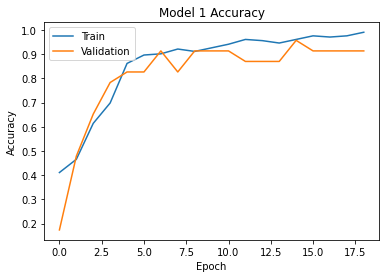

In [82]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

The validation accuracy rapidly improves in the first 4 cycles, but there is more convergence of the accuracy of the training testing datasets as the cycles approaches the 19 cycle limit, where we see both the training and validation set exceed 90% accuracy. Let's evaluate the accuracy of the mode.

In [83]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 0s - 65ms/step - accuracy: 1.0000 - loss: 0.0579


## Confusion Matrix & Interpretation ##
Let's now plot a confusion matrix for our results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


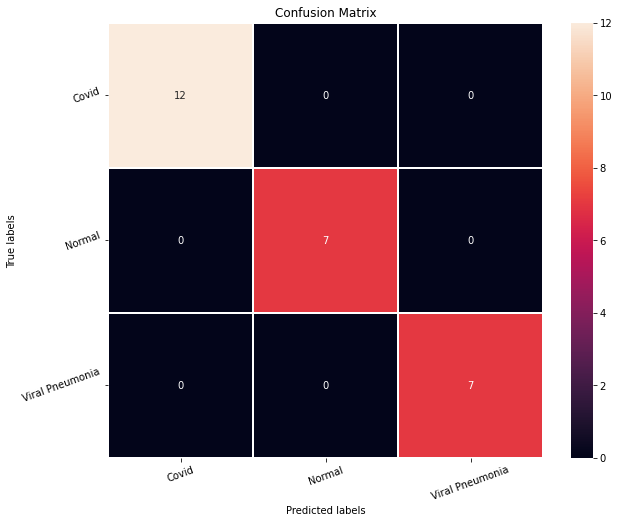

In [84]:
# Obtain output as probablities for each category
y_pred = model1.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred by obtaining the the max value
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)
#First, let's create the confusion matrix of the categorical variables
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
#Create figure and confusion matrix sub-plots
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)
#Set up labels and titles
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()




We can see that the model accurately predicted with high probability each label.

## Conclusions

In conclusion, the model demonstrated excellent performance across all evaluation stages:

Training Accuracy: 99.1%

Validation Accuracy: 91.3%

Test Accuracy: 100% (accuracy = 1.0000, loss = 0.0579)

Final Training Loss: 0.0421

Validation Loss: 0.2412

Test Loss: 0.0579

Confusion Matrix: 100% classification accuracy — all test samples correctly classified across all three classes (Covid, Normal, Viral Pneumonia).